In [2]:
import torch
import torchvision
import os
from pathlib import Path

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, RandomSampler, Subset
from torchvision import transforms
from torch.nn import MSELoss
from captum.attr import IntegratedGradients

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

from lfxai.models.images import AutoEncoderMnist, EncoderMnist, DecoderMnist
from lfxai.models.pretext import Identity, RandomNoise
from lfxai.explanations.features import attribute_auxiliary
from lfxai.explanations.examples import TracIn
from lfxai.utils.metrics import (
    compute_metrics,
    cos_saliency,
    count_activated_neurons,
    entropy_saliency,
    pearson_saliency,
    similarity_rates,
    spearman_saliency,
)

In [3]:
# Parameters
random_seed: int = 1
batch_size: int = 200
dim_latent: int = 4
n_epochs: int = 100
subtrain_size: int = 1000

# Select torch device
torch.random.manual_seed(random_seed)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# Load MNIST
data_dir = Path.cwd() / "data/mnist"
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
train_dataset.transform = train_transform
test_dataset.transform = test_transform
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 119526763.31it/s]


Extracting /content/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23394301.63it/s]


Extracting /content/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29785868.27it/s]


Extracting /content/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20752209.99it/s]


Extracting /content/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/mnist/MNIST/raw



In [5]:
# Initialize encoder, decoder and autoencoder wrapper
pert = RandomNoise()
encoder = EncoderMnist(encoded_space_dim=dim_latent)
decoder = DecoderMnist(encoded_space_dim=dim_latent)
autoencoder = AutoEncoderMnist(encoder, decoder, dim_latent, pert)
encoder.to(device)
decoder.to(device)
autoencoder.to(device)

# Train the denoising autoencoder
save_dir = Path.cwd() / "results/mnist/consistency_examples"
if not save_dir.exists():
    os.makedirs(save_dir)
autoencoder.fit(
    device, train_loader, test_loader, save_dir, n_epochs, checkpoint_interval=10
)
autoencoder.load_state_dict(
    torch.load(save_dir / (autoencoder.name + ".pt")), strict=False
)
autoencoder.train().to(device)

AutoEncoderMnist(
  (encoder): EncoderMnist(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (6): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=288, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (decoder): DecoderMnist(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim

In [6]:
print('Validation loss: ', autoencoder.test_epoch(device, test_loader))

Validation loss:  0.026415925


In [7]:
idx_subtrain = [
    torch.nonzero(train_dataset.targets == (n % 10))[n // 10].item()
    for n in range(subtrain_size)
]

idx_subtest = [
    torch.nonzero(test_dataset.targets == (n % 10))[n // 10].item()
    for n in range(subtrain_size)
]

train_subset = Subset(train_dataset, idx_subtrain)
test_subset = Subset(test_dataset, idx_subtest)
subtrain_loader = DataLoader(train_subset)
subtest_loader = DataLoader(test_subset)
labels_subtrain = torch.cat([label for _, label in subtrain_loader])
labels_subtest = torch.cat([label for _, label in subtest_loader])

In [8]:
indexes = [i for i in range(len(test_dataset))]
idx_not_subtest = list(set(indexes) - set(idx_subtest))
test_not_subset = Subset(test_dataset, idx_not_subtest)
test_not_subset_loader = DataLoader(test_not_subset)
len(subtest_loader), len(test_not_subset_loader)

(1000, 9000)

In [9]:
print('Test loss: ', autoencoder.test_epoch(device, test_not_subset_loader))

Test loss:  0.026329791


In [10]:
# Create a training set sampler with replacement for computing influence functions
recursion_depth = 100
train_sampler = RandomSampler(
    train_dataset, replacement=True, num_samples=recursion_depth * batch_size
)
train_loader_replacement = DataLoader(
    train_dataset, batch_size, sampler=train_sampler
)

# Fitting explainers, computing the metric and saving everything
mse_loss = torch.nn.MSELoss()
explainer_list = [
    TracIn(autoencoder, mse_loss, save_dir / "tracin_grads")
]

frac_list = [0.05, 0.1, 0.2, 0.5, 0.7, 1.0]
n_top_list = [int(frac * len(idx_subtrain)) for frac in frac_list]
results_dict = {}
for explainer in explainer_list:
    attribution = explainer.attribute_loader(
        device,
        subtrain_loader,
        subtest_loader,
        train_loader_replacement=train_loader_replacement,
        recursion_depth=recursion_depth,
    )
    autoencoder.load_state_dict(
        torch.load(save_dir / (autoencoder.name + ".pt")), strict=False
    )
    results_dict[str(explainer)] = attribution

100%|██████████| 1000/1000 [00:05<00:00, 252.03example/s]
                                                         
 98%|█████████▊| 981/1000 [00:03<00:00, 269.86example/s]
                                                        

  0%|          | 0/1000000 [00:00<?, ?it/s]

 99%|█████████▉| 992/1000 [00:03<00:00, 267.39example/s]
                                                        
100%|█████████▉| 999/1000 [00:03<00:00, 269.20example/s]
                                                        

  0%|          | 0/1000000 [00:00<?, ?it/s]

 98%|█████████▊| 984/1000 [00:03<00:00, 255.32example/s]
                                                        
 99%|█████████▉| 994/1000 [00:06<00:00, 245.89example/s]
                                                        

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|█████████▉| 995/1000 [00:04<00:00, 249.99example/s]
                                                        
 99%|█████████▉| 990/1000 [00:06<00:00, 242.73example/s]
                                                        

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|█████████▉| 995/1000 [00:04<00:00, 190.33example/s]
                                                        
100%|█████████▉| 999/1000 [00:04<00:00, 242.96example/s]
                                                        

  0%|          | 0/1000000 [00:00<?, ?it/s]

 99%|█████████▊| 986/1000 [00:04<00:00, 253.75example/s]
                                                        
 99%|█████████▉| 993/1000 [00:04<00:00, 228.17example/s]
                                                        

  0%|          | 0/1000000 [00:00<?, ?it/s]

 99%|█████████▉| 989/1000 [00:04<00:00, 205.66example/s]
                                                        
 98%|█████████▊| 978/1000 [00:05<00:00, 244.73example/s]
                                                        

  0%|          | 0/1000000 [00:00<?, ?it/s]

 98%|█████████▊| 982/1000 [00:04<00:00, 246.94example/s]
                                                        
100%|█████████▉| 998/1000 [00:04<00:00, 250.38example/s]
                                                        

  0%|          | 0/1000000 [00:00<?, ?it/s]

 99%|█████████▉| 990/1000 [00:03<00:00, 246.91example/s]
                                                        
 98%|█████████▊| 977/1000 [00:04<00:00, 255.85example/s]
                                                        

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [11]:
import pickle
with open('results/mnist/consistency_examples/results_dict.pkl','wb') as handle:
    pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
results_list = []

for explainer in results_dict.keys():
    attribution = results_dict[explainer]
    sim_most, sim_least = similarity_rates(
        attribution, labels_subtrain, labels_subtest, n_top_list
    )
    results_list += [
        [str(explainer), "Most Important", 100 * frac, sim]
        for frac, sim in zip(frac_list, sim_most)
    ]
    results_list += [
        [str(explainer), "Least Important", 100 * frac, sim]
        for frac, sim in zip(frac_list, sim_least)
    ]
    results_df = pd.DataFrame(
    results_list,
    columns=[
        "Explainer",
        "Type of Examples",
        "% Examples Selected",
        "Similarity Rate",
    ],
    )

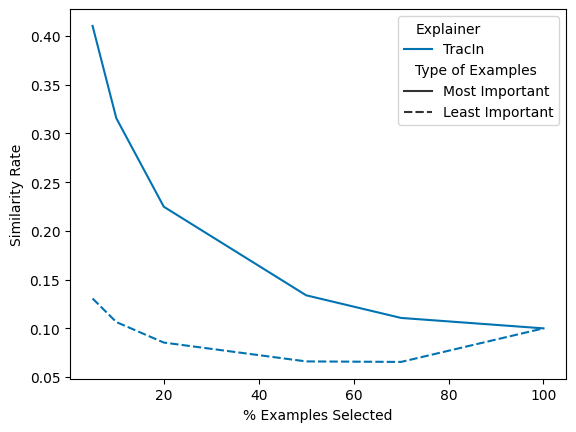

In [13]:
# Checking that results are consistent with paper
results_df.to_csv(save_dir / "metrics.csv")
sns.lineplot(
data=results_df,
x="% Examples Selected",
y="Similarity Rate",
hue="Explainer",
style="Type of Examples",
palette="colorblind",
)
plt.savefig(save_dir / "similarity_rates.pdf")

# Retraining model without opponents

In [14]:
opponents_index = (results_dict['TracIn'].mean(axis=0) < 0).nonzero().flatten()

In [18]:
len(opponents_index)

122

In [15]:
# Custom class to remove opponents from training dataset
from CustomMNIST import CustomMNIST

data_dir = Path.cwd() / "data/mnist"

train_dataset = CustomMNIST(data_dir, train=True, download=True)
test_dataset = CustomMNIST(data_dir, train=False, download=True)

len(train_dataset), len(test_dataset)

100%|██████████| 9912422/9912422 [00:00<00:00, 113738099.75it/s]


Extracting /content/data/mnist/CustomMNIST/raw/train-images-idx3-ubyte.gz to /content/data/mnist/CustomMNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105795365.79it/s]


Extracting /content/data/mnist/CustomMNIST/raw/train-labels-idx1-ubyte.gz to /content/data/mnist/CustomMNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24684889.36it/s]


Extracting /content/data/mnist/CustomMNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/mnist/CustomMNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2248380.59it/s]


Extracting /content/data/mnist/CustomMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/mnist/CustomMNIST/raw



(60000, 10000)

In [16]:
# remove the 122 oponents from the training set
for i in opponents_index:
    train_dataset.remove_example(i)

In [17]:
len(train_dataset)

59878

In [19]:
# Initialize seed and device
torch.random.manual_seed(random_seed)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [20]:
# Autoencoder model without oponents
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
train_dataset.transform = train_transform
test_dataset.transform = test_transform
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

# Initialize encoder, decoder and autoencoder wrapper
pert = RandomNoise()
encoder = EncoderMnist(encoded_space_dim=dim_latent)
decoder = DecoderMnist(encoded_space_dim=dim_latent)
autoencoder = AutoEncoderMnist(encoder, decoder, dim_latent, pert)
encoder.to(device)
decoder.to(device)
autoencoder.to(device)

# Train the denoising autoencoder
save_dir = Path.cwd() / "results/mnist/proponents_examples"
if not save_dir.exists():
    os.makedirs(save_dir)
if not (save_dir / (autoencoder.name + ".pt")).exists():
    autoencoder.fit(
        device, train_loader, test_loader, save_dir, n_epochs, checkpoint_interval=10
    )
else:
    autoencoder.load_state_dict(
        torch.load(save_dir / (autoencoder.name + ".pt")), strict=False
    )
autoencoder.train().to(device)

AutoEncoderMnist(
  (encoder): EncoderMnist(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (6): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=288, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (decoder): DecoderMnist(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim

In [21]:
print('Validation loss: ', autoencoder.test_epoch(device, test_loader))

Validation loss:  0.026258526


In [22]:
indexes = [i for i in range(len(test_dataset))]
idx_not_subtest = list(set(indexes) - set(idx_subtest))
test_not_subset = Subset(test_dataset, idx_not_subtest)
test_not_subset_loader = DataLoader(test_not_subset)
len(subtest_loader), len(test_not_subset_loader)

(1000, 9000)

In [23]:
print('Test loss: ', autoencoder.test_epoch(device, test_not_subset_loader))

Test loss:  0.026138412


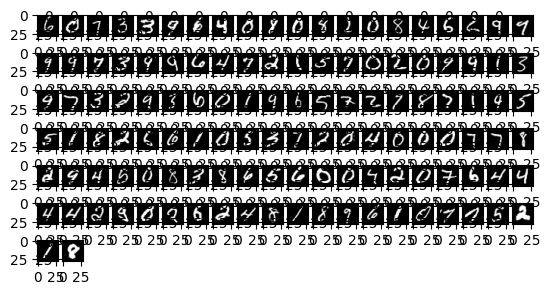

In [25]:
for i in range(122):
    # plot opponent samples
    plt.subplot(10, 20, i + 1)
    plt.imshow(train_dataset.data[idx_subtrain[opponents_index[i]]], cmap="gray")